# Прогнозирование уровня средней заработной платы в России
Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России.

В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016. Если хотите, можете дописать в конец ряда данные за следующие месяцы, если они уже опубликованы; найти эти данные можно, например, здесь.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Придерживайтесь стандартного алгоритма построения прогноза:

1. Визуальный анализ ряда
2. Стабилизация дисперсии (при необходимости)
3. Выбор порядка дифференцирования
4. Выбор начальных приближений для $p,q,P,Q$
5. Обучение и сравнение моделей-кандидатов, выбор победителя
6. Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p,q,P,Q$.
7. Прогнозирование с помощью финальной модели.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
salary = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


### Анализ временного ряда

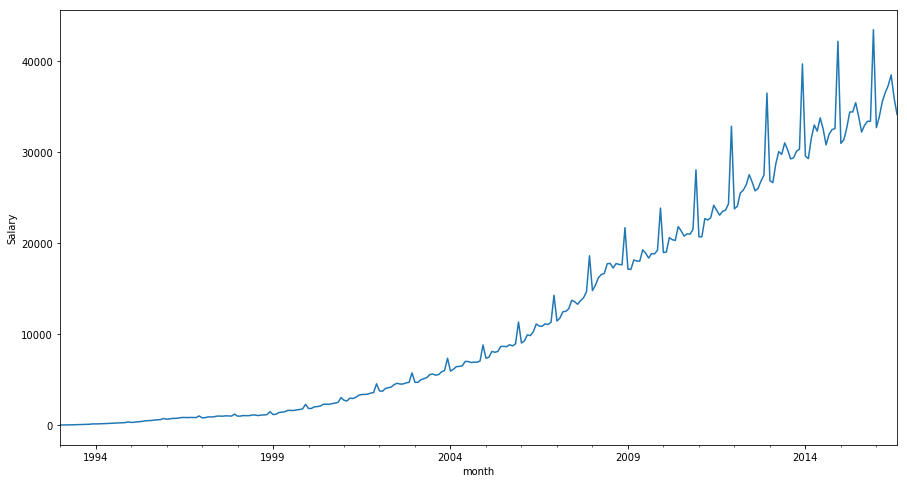

In [4]:
plt.figure(figsize(15, 8))
salary.WAG_C_M.plot()
plt.ylabel('Salary')
plt.show()

Проверка стационарности и STL-декомпозиция ряда

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

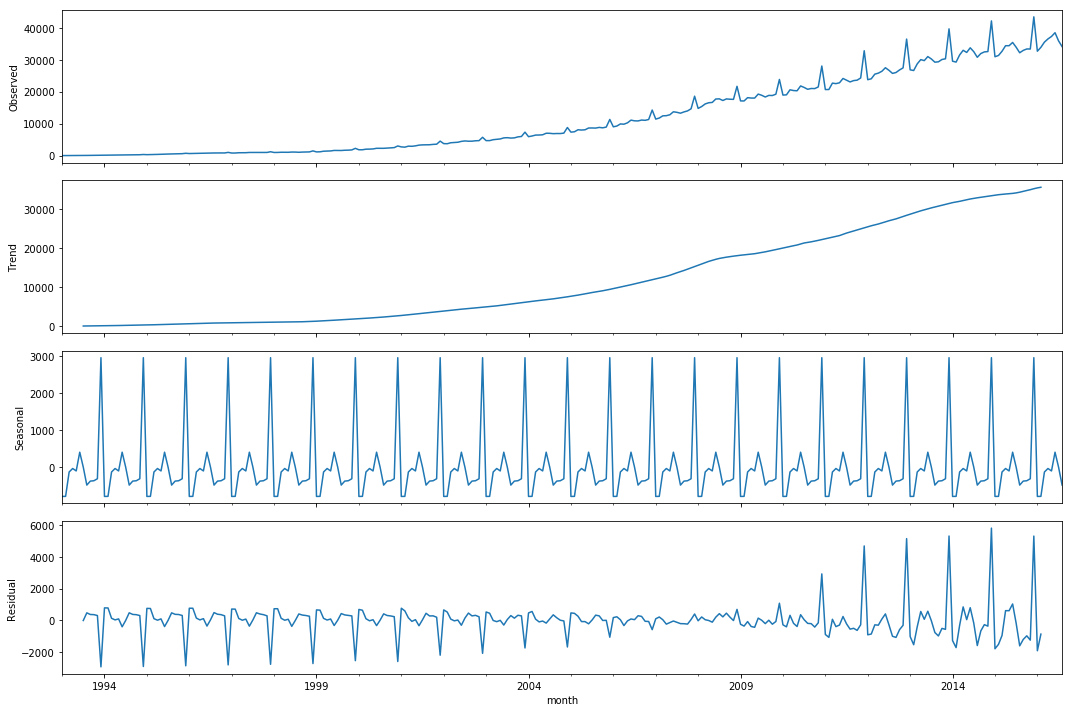

In [5]:
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.WAG_C_M)[1])

По визуальному анализу временного ряда ясно, что ряд не стационарен. По критерию Дика-Фуллера также предположение о нестационарности ряда не отвергается.
Очивидно по визуальному анализу и по STL-декомпозиции, что данный временной ряд имеет сильновыроженную тенденцию и годовую сезонность.

Также видно, дисперсия меняется со временем, поэтому проведем преобразование Бокса-Кокса для стабилизации дисперсии.

### Стабилиация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


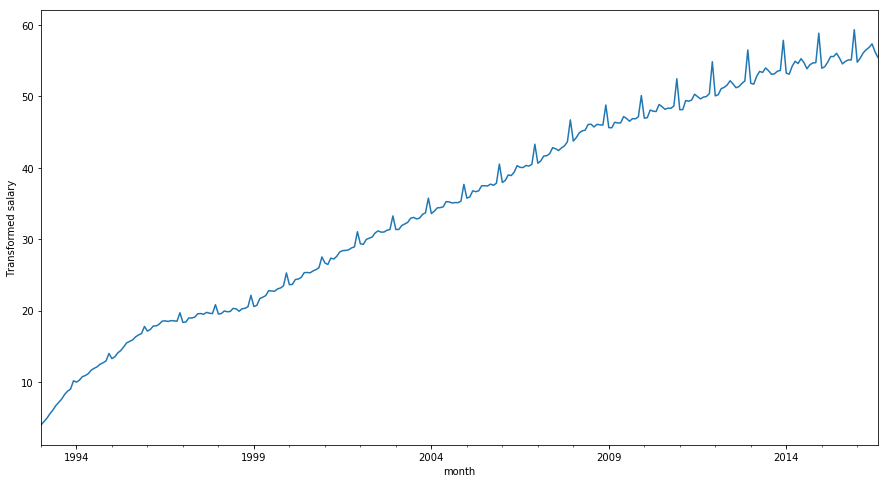

In [6]:
salary['salary_box'], lmbda = stats.boxcox(salary.WAG_C_M)
plt.figure(figsize(15, 8))
salary.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box)[1])

После стабилизации дисперсии очивидно, что временной ряд все еще не стационарен. По критерию Дики-Фуллера также гипотиза о нестационарности не отвергается.

### Сезонное дифференцирование

Для приведения временного ряда к состоянию стационарности, избавимся от сезонности, проведыя сезонное дифференцирование.

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

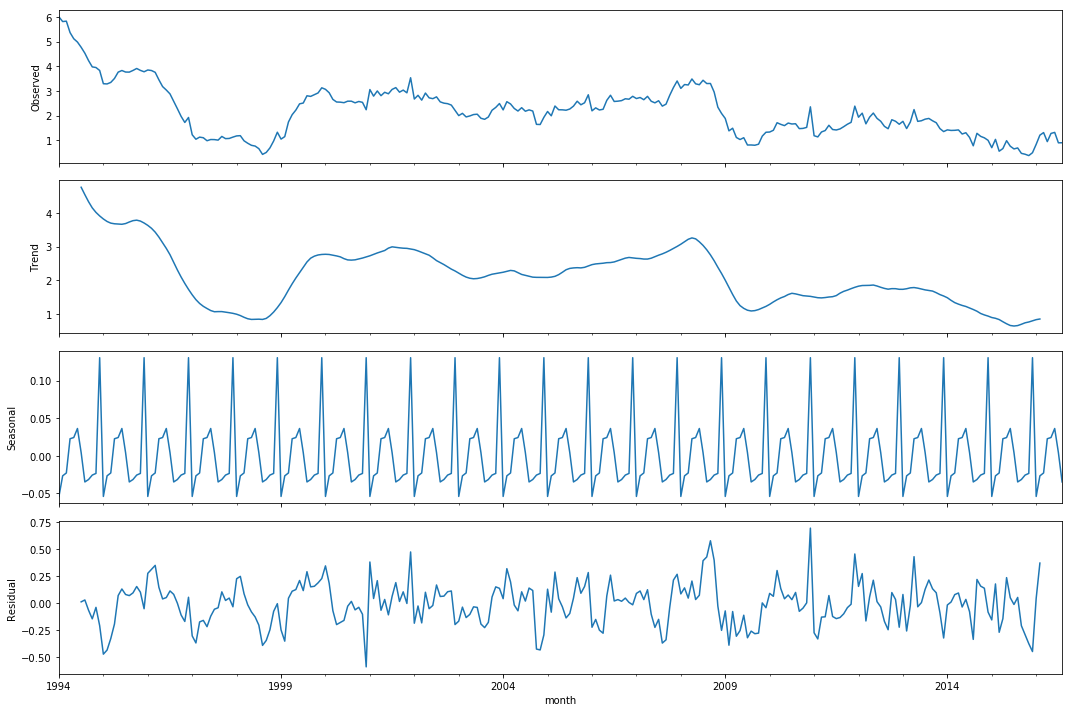

In [7]:
salary['salary_box_diff'] = salary.salary_box - salary.salary_box.shift(12)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(salary.salary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff[12:])[1])

По продифференцированному ряду и результатам STL-декомпозиции видно, что сезонность была почти полностью убрана, а тренд стал менее выроженным, но все еще заметным. Несмотря на то, что критерий Дики-Фуллера отвергает гипотезу о нестационарности, для компенсации остаточного тренда проведем еще одно дифференцирование.

### Дифференцирование

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

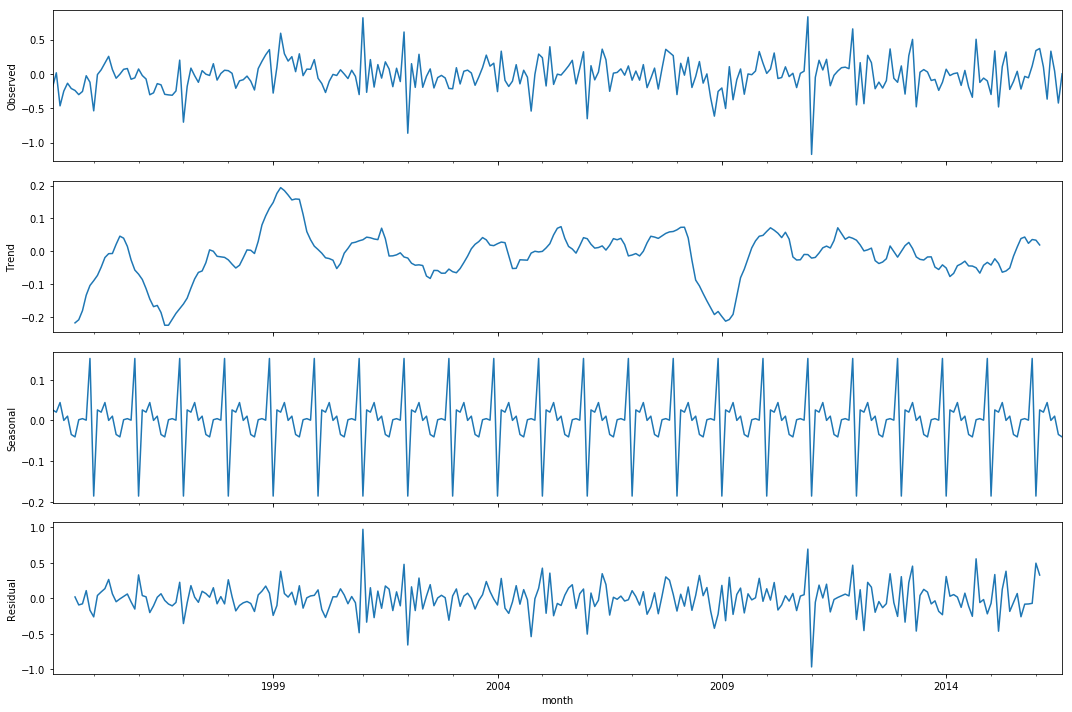

In [8]:
salary['salary_box_diff2'] = salary.salary_box_diff - salary.salary_box_diff.shift(1)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(salary.salary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(salary.salary_box_diff2[13:])[1])

Критерий Дики-Фуллера с уверенностью отвергает гипотезу о нестационарности данного временного ряда.
По результатам STL-декомпозиции видно, что тренда и сезонности практически нет, а остатоквсе время колеблится около нуля.

### Подбор модели

Построим коррелограмму и частичную коррелограмму полученного временного ряда.

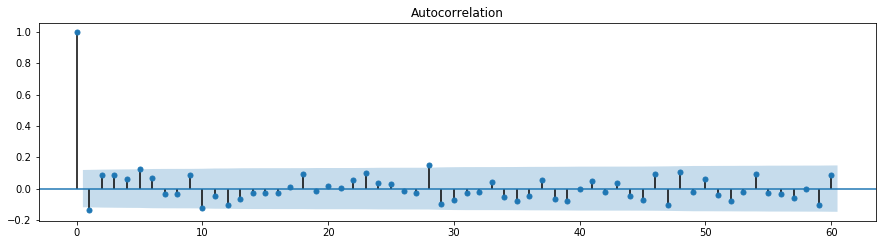

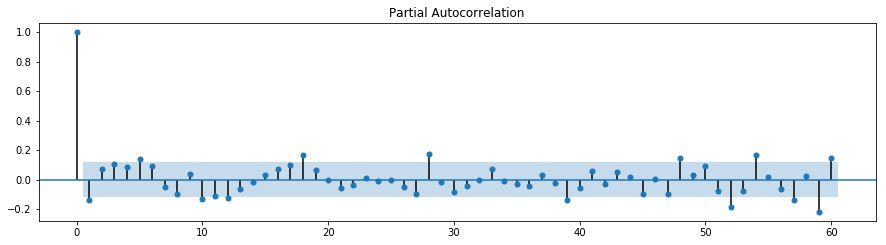

In [9]:
plt.figure(figsize(15, 8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(salary.salary_box_diff2[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(salary.salary_box_diff2[13:].values.squeeze(), lags=60, ax=ax)
pylab.show()

Выберем следующие начальные приближения:
Q = 1,
q = 4,
P = 1,
p = 5.

In [10]:
d = 1
D = 1
Qs = range(0, 2)
qs = range(0, 5)
Ps = range(0, 2)
ps = range(0, 6)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

120

In [12]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(salary.salary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 2min 51s, sys: 2.47 s, total: 2min 54s
Wall time: 2min 27s


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(10))

      parameters        aic
48  (2, 2, 0, 0) -21.488586
50  (2, 2, 1, 0) -21.473462
49  (2, 2, 0, 1) -21.240103
52  (2, 3, 0, 0) -21.091493
51  (2, 2, 1, 1) -21.053101
54  (2, 3, 1, 0) -20.398609
68  (3, 2, 0, 0) -20.248459
53  (2, 3, 0, 1) -20.140422
70  (3, 2, 1, 0) -19.691253
56  (2, 4, 0, 0) -19.586582


Модель наилучшая по aic также является достаточно простой, поэтому выбираем именно ее:

In [14]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                         salary_box   No. Observations:                  284
Model:             SARIMAX(2, 1, 2)x(0, 1, 0, 12)   Log Likelihood                  15.744
Date:                            Sat, 13 Feb 2021   AIC                            -21.489
Time:                                    03:08:50   BIC                             -3.478
Sample:                                01-01-1993   HQIC                           -14.257
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4854      0.044     33.922      0.000       1.400       1.571
ar.L2         -0.6837      0.043   

Проанализируем остатки

Критерий Стьюдента: p=0.269874
Критерий Дики-Фуллера: p=0.000000


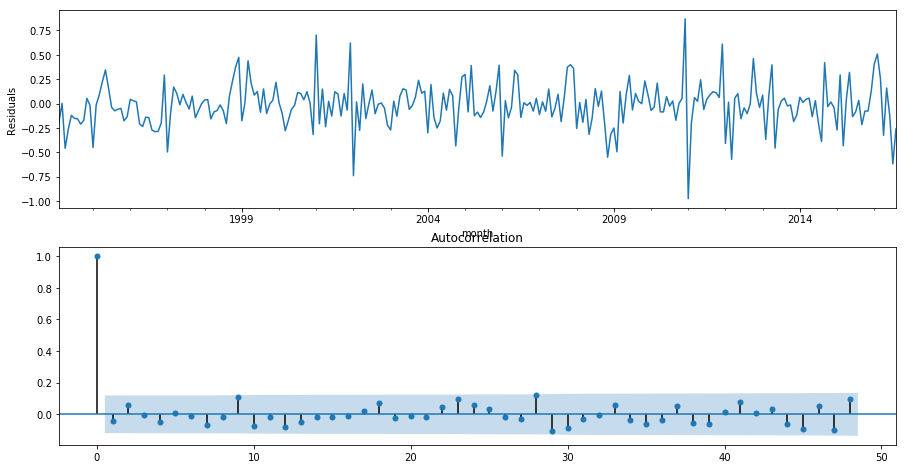

In [15]:
plt.figure(figsize(15, 8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Визуально остатки кажутся стационарными и несмещенными отностительно нуля. Это подтверждается критерием Стьюдента, который не отвергает гипотезу о несмещенности остатков относительно нуля и критерием Дики-Фуллера, который отвергает гипотезу о их нестационарности. Также по коррелограмме, на которой нету значимых лагов, видно, что остатки неавтокоррелированы.

Построим временной ряд по выбранной модели за период, для которого известны значения данного ряда и сравним с данным временным рядом.

Для построения временного ряда по модели необходимо реализовать функцию, обратную преобразованию Бокса-Кокса:

In [16]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

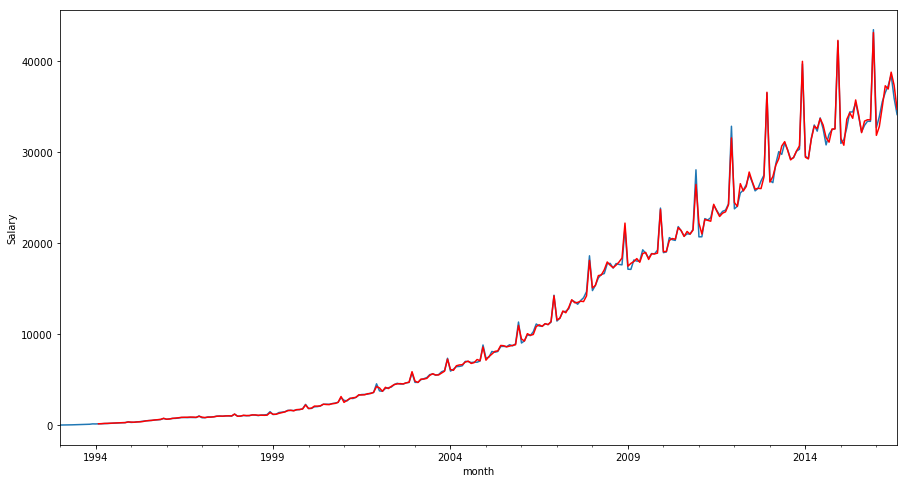

In [17]:
salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15, 8))
salary.WAG_C_M.plot()
salary.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

Визуально видно, что ряд, полученный по модели и данный очень похожи.

# Прогноз

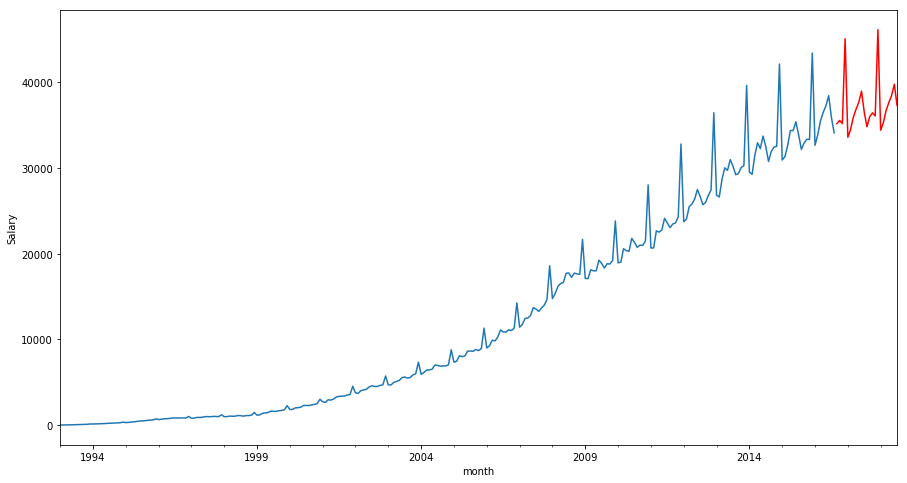

In [18]:
salary2 = salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 24)]
future = pd.DataFrame(index=date_list, columns= salary2.columns)
salary2 = pd.concat([salary2, future])
salary2['forecast'] = invboxcox(best_model.predict(start=len(salary), end=len(salary) + 24), lmbda)

plt.figure(figsize(15, 8))
salary.WAG_C_M.plot()
salary2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()